In [1]:
import datetime
import os
from pathlib import Path
import pickle
import random
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, StochasticWeightAveraging, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from sklearn.model_selection import train_test_split
import timm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Precision, Recall
from torchmetrics.functional.classification import multiclass_confusion_matrix, multiclass_f1_score

from configs.config import CFG
from ema.ema import EMACallback
from model.multitask_unet import MultiTaskUNet
from util.get_logger import get_logger
from util.my_dataset import MyDataModule, MyDataset


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

In [2]:
import timm.optim


class LitUNetModel(L.LightningModule):
    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            num_classes: int,
            height: int,
            width: int,
            learning_rate: float,
            mean_y: torch.Tensor,
            std_y: torch.Tensor,
        ) -> None:

        super().__init__()
        self.model = MultiTaskUNet(model_name, num_classes, pretrained, height, width)
        self.num_classes = num_classes
        self.criterion1 = nn.SmoothL1Loss()
        self.criterion2 = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.mean_y = mean_y
        self.std_y = std_y
        self.alpha = 1e-02
        self.save_hyperparameters(ignore=["criterion1", "criterion2"])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        reg_logit, clf_logit = self.model(x)
        pred_class = clf_logit.argmax(dim=1)
        mean_by_class = self.mean_y[pred_class]
        std_by_class = self.std_y[pred_class]
        reg_logit = reg_logit * std_by_class + mean_by_class
        reg_logit = torch.clip(reg_logit, min=1500, max=4500)
        return reg_logit, clf_logit

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        x, y, label, _ = batch
        batch_size = len(x)
        reg_logit, clf_logit = self.forward(x)
        loss1 = self.criterion1(reg_logit, y)
        loss2 = self.criterion2(clf_logit, label)
        loss3 = self._edge_loss(reg_logit, y)
        loss = loss1 + loss2 + self.alpha * loss3
        lr = self.optimizer.param_groups[0]["lr"]
        self.log("train_loss1", loss1, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_loss2", loss2, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_loss3", loss3, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("lr", lr, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss
    
    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        x, y, label, _ = batch
        batch_size = len(x)
        reg_logit, clf_logit = self.forward(x)
        loss1 = F.l1_loss(reg_logit, y)
        loss2 = F.cross_entropy(clf_logit, label)
        loss3 = self._edge_loss(reg_logit, y)
        loss = loss1 + loss2 + self.alpha * loss3
        f1 = multiclass_f1_score(clf_logit, label, num_classes=self.num_classes, average="macro")
        self.log("val_loss1", loss1, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_loss2", loss2, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_loss3", loss3, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss
    
    def on_test_epoch_start(self):
        self.clf_targets = []
        self.clf_preds = []
        self.mae_all = 0
        self.num_data = 0
    
    def test_step(
            self,
            batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
            batch_idx: int
        ) -> Dict[str, float]:
        
        x, y, label, path = batch
        batch_size = len(x)
        reg_logit, clf_logit = self.forward(x)
        loss1 = F.l1_loss(reg_logit, y)
        loss2 = F.cross_entropy(clf_logit, label)
        loss3 = self._edge_loss(reg_logit, y)
        loss = loss1 + loss2 + self.alpha * loss3
        f1 = multiclass_f1_score(clf_logit, label, num_classes=self.num_classes, average="macro")
        self.mae_all += F.l1_loss(reg_logit, y, reduction="sum")
        self.num_data += len(x)

        self.clf_targets.append(label.cpu())
        self.clf_preds.append(clf_logit.argmax(dim=1).cpu())
        
        self.log("test_loss1", loss1, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_loss2", loss2, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_loss3", loss3, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        
        # if batch_idx == 0:
        #     print(path[0])
        #     _, axs = plt.subplots(1, 8, figsize=(32, 8))
        #     for i in range(5):
        #         im0 = axs[i].imshow(x.float()[0, i].cpu(), aspect="auto")
        #         plt.colorbar(im0, ax=axs[i])
        #     im1 = axs[5].imshow(reg_logit.float()[0, 0].cpu(), aspect="auto")
        #     im2 = axs[6].imshow(y.float()[0, 0].cpu(), aspect="auto")
        #     im3 = axs[7].imshow(y.float()[0, 0].cpu()-reg_logit.float()[0, 0].cpu(), aspect="auto")
        #     plt.colorbar(im1, ax=axs[5])
        #     plt.colorbar(im2, ax=axs[6])
        #     plt.colorbar(im3, ax=axs[7])
        #     plt.suptitle(path[0])
        #     plt.tight_layout()
        #     plt.show()

        return {"loss": loss}
    
    def on_test_epoch_end(self):
        clf_targets = torch.cat(self.clf_targets)
        clf_preds = torch.cat(self.clf_preds)
        cm = multiclass_confusion_matrix(clf_preds, clf_targets, num_classes=self.num_classes)
        print(cm)
        print(f"Test MAE: {self.mae_all / self.num_data / 70 / 70:.4f}")
        print(f"# of test data: {self.num_data}")
        del self.clf_targets
        del self.clf_preds
    
    def predict_step(self, batch: List[Union[Tuple[str], torch.Tensor]]) -> Tuple[str, torch.Tensor, torch.Tensor]:
        file_names, x = batch
        reg_logit, clf_logit = self.forward(x)
        return file_names, reg_logit, clf_logit

    def configure_optimizers(self) -> Dict[str, object]:
        self.optimizer = timm.optim.create_optimizer_v2(self, opt="adamw", lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=self.optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.3,
            div_factor=25,
            final_div_factor=1e+04,
        )
        # self.scheduler = ConstantCosineLR(self.optimizer, total_steps=self.trainer.estimated_stepping_batches, pct_cosine=0.41)
        scheduler_config = {
            "scheduler": self.scheduler,
            "interval": "step",
            "frequency": 1,
            "monitor": "val_loss",
            "strict": False,
        }
        return (
            {
                "optimizer": self.optimizer,
                "lr_scheduler": scheduler_config,
            },
        )
    
    def _total_variation_loss(self, img):
        loss = (
            torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
            + torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
        )
        return loss
    
    def _get_sobel_edges(self, x):
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=x.dtype, device=x.device).view(1, 1, 3, 3)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=x.dtype, device=x.device).view(1, 1, 3, 3)
        
        if x.shape[1] > 1:
            x = x.mean(dim=1, keepdim=True)

        grad_x = F.conv2d(x, sobel_x, padding=1)
        grad_y = F.conv2d(x, sobel_y, padding=1)
        edge = torch.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-6)
        return edge
    
    def _edge_loss(self, pred, target):
        pred_edge = self._get_sobel_edges(pred)
        target_edge = self._get_sobel_edges(target)
        return F.l1_loss(pred_edge, target_edge)

In [3]:
checkpoint_path = "../output/multitask_using_AB_v2_2025-06-27-19-18/model-epoch=99-val_loss1=28.88.ckpt"
model = LitUNetModel.load_from_checkpoint(checkpoint_path)

script = model.to_torchscript()

# save for use in production environment
torch.jit.save(script, "model_scripted.pt")

scripted_model = torch.jit.load("model_scripted.pt")
scripted_model.eval()

0 torch.Size([1, 128, 72, 72])
1 torch.Size([1, 256, 36, 36])
2 torch.Size([1, 512, 18, 18])
3 torch.Size([1, 1024, 9, 9])
[(1024, 9, 9), (512, 18, 18), (256, 36, 36), (128, 72, 72)]
FeatureListNet(
  (stem): Downsample(
    (proj): Conv2d(5, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers_0): FocalNetStage(
    (downsample): Identity()
    (blocks): ModuleList(
      (0): FocalNetBlock(
        (norm1): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
        (modulation): FocalModulation(
          (f): Conv2d(128, 260, kernel_size=(1, 1), stride=(1, 1))
          (h): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (act): GELU(approximate='none')
          (proj): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (proj_drop): Dropout(p=0.0, inplace=False)
          (focal_layers): ModuleList(
            (0): Sequential(
              (0): Conv2d(128, 128, kernel_size=(3, 3), s

RecursiveScriptModule(
  original_name=LitUNetModel
  (model): RecursiveScriptModule(
    original_name=MultiTaskUNet
    (encoder): RecursiveScriptModule(
      original_name=FeatureListNet
      (stem): RecursiveScriptModule(
        original_name=Downsample
        (proj): RecursiveScriptModule(original_name=Conv2d)
        (norm): RecursiveScriptModule(original_name=LayerNorm2d)
      )
      (layers_0): RecursiveScriptModule(
        original_name=FocalNetStage
        (downsample): RecursiveScriptModule(original_name=Identity)
        (blocks): RecursiveScriptModule(
          original_name=ModuleList
          (0): RecursiveScriptModule(
            original_name=FocalNetBlock
            (norm1): RecursiveScriptModule(original_name=LayerNorm2d)
            (modulation): RecursiveScriptModule(
              original_name=FocalModulation
              (f): RecursiveScriptModule(original_name=Conv2d)
              (h): RecursiveScriptModule(original_name=Conv2d)
              (act

In [4]:
families = {
    "CurveFault_A": 0,
    "CurveFault_B": 1,
    "CurveVel_A": 2,
    "CurveVel_B": 3,
    "FlatFault_A": 4,
    "FlatFault_B": 5,
    "FlatVel_A": 6,
    "FlatVel_B": 7,
    "Style_A": 8,
    "Style_B": 9,
}

In [5]:
mean_x = []
std_x = []
mean_y = []
std_y = []
with open("../output/statistics.pkl", "rb") as f:
    statistics = pickle.load(f)
    mean_x.append(list(statistics["All"]["mean_log_x"]))
    std_x.append(list(statistics["All"]["std_log_x"]))
    for f in families.keys():
        mean_y.append(statistics[f]["mean_y"])
        std_y.append(statistics[f]["std_y"])
mean_x = torch.tensor(mean_x).reshape(-1, 1, 1)
std_x = torch.tensor(std_x).reshape(-1, 1, 1)
mean_y = torch.tensor(mean_y).reshape(-1, 1, 1, 1)
std_y = torch.tensor(std_y).reshape(-1, 1, 1, 1)
print(mean_x)
print(std_x)
print(mean_y)
print(std_y)

tensor([[[-0.0271]],

        [[-0.0343]],

        [[-0.0356]],

        [[-0.0343]],

        [[-0.0274]]], dtype=torch.float64)
tensor([[[0.4190]],

        [[0.4667]],

        [[0.4752]],

        [[0.4660]],

        [[0.4196]]], dtype=torch.float64)
tensor([[[[3082.6657]]],


        [[[3035.7756]]],


        [[[2788.1563]]],


        [[[2999.8506]]],


        [[[3088.8689]]],


        [[[3055.7837]]],


        [[[2782.0442]]],


        [[[3001.3388]]],


        [[[2728.6833]]],


        [[[2837.6179]]]], dtype=torch.float64)
tensor([[[[852.4635]]],


        [[[890.2442]]],


        [[[794.2430]]],


        [[[866.0826]]],


        [[[854.9825]]],


        [[[875.8455]]],


        [[[786.1555]]],


        [[[866.6634]]],


        [[[666.2065]]],


        [[[637.9381]]]], dtype=torch.float64)


In [6]:
from util.log_transform import log_transform_torch


image = np.load("../data/FlatFault_A/seis2_1_4_vel2_1_4_364.npz")
x = torch.from_numpy(image["x"]).float()
# x = F.pad(x, pad=(1, 1, 76, 76), mode="reflect")
x = log_transform_torch(x)
x = (x - mean_x) / std_x
print(x.shape, mean_x.shape, std_x.shape)

x = x.unsqueeze(dim=0)
x = F.interpolate(x, size=(288, 288), mode="bicubic", align_corners=True)
x = x.float()
print(x.shape)

y = image["y"].astype(np.float32)

x = x.to("cuda").float()

model = model.to("cuda")
model.eval()

scripted_model = scripted_model.to("cuda")
scripted_model.eval()

reg, clf = model(x)
reg_scripted, clf_scripted = scripted_model(x)

reg = reg.cpu().detach().numpy()
clf = clf.cpu().detach().numpy()
reg_scripted = reg_scripted.cpu().detach().numpy()
clf_scripted = clf_scripted.cpu().detach().numpy()
print(reg.shape, clf.shape)
print(reg_scripted.shape, clf_scripted.shape)

torch.Size([5, 1000, 70]) torch.Size([5, 1, 1]) torch.Size([5, 1, 1])
torch.Size([1, 5, 288, 288])
(1, 1, 70, 70) (1, 10)
(1, 1, 70, 70) (1, 10)


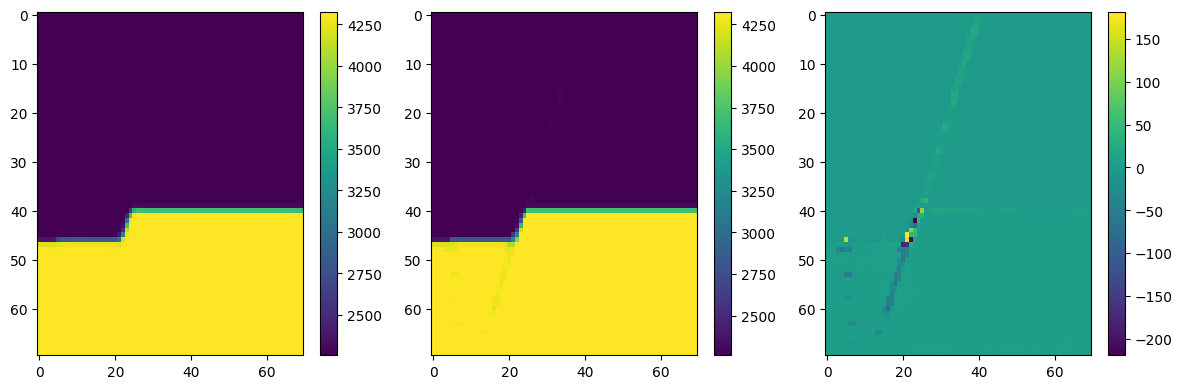

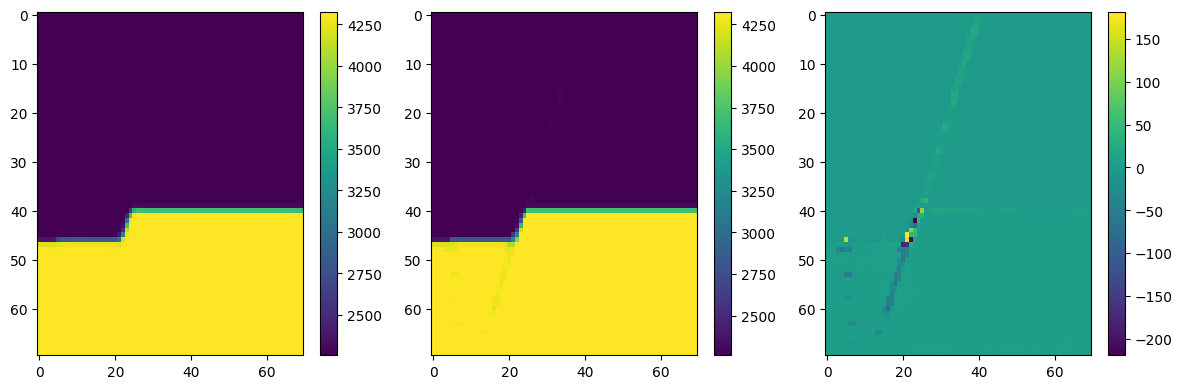

In [7]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
img0 = axs[0].imshow(reg[0, 0], aspect="auto")
img1 = axs[1].imshow(y[0], aspect="auto")
img2 = axs[2].imshow(y[0]-reg[0, 0], aspect="auto")
plt.colorbar(img0, ax=axs[0])
plt.colorbar(img1, ax=axs[1])
plt.colorbar(img2, ax=axs[2])
plt.tight_layout()
plt.show()

_, axs = plt.subplots(1, 3, figsize=(12, 4))
img0 = axs[0].imshow(reg_scripted[0, 0], aspect="auto")
img1 = axs[1].imshow(y[0], aspect="auto")
img2 = axs[2].imshow(y[0]-reg[0, 0], aspect="auto")
plt.colorbar(img0, ax=axs[0])
plt.colorbar(img1, ax=axs[1])
plt.colorbar(img2, ax=axs[2])
plt.tight_layout()
plt.show()

In [9]:
(reg - reg_scripted).mean()

np.float64(0.0)